<a href="https://colab.research.google.com/github/thuyk39nguyen/AIO/blob/main/Modul6_week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Weather Classification**

 2. Import các thư viện cần thiết:

In [ ]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
!unzip('/content/img_cls_weather_dataset.zip')

/bin/bash: -c: line 1: syntax error near unexpected token `'/content/img_cls_weather_dataset.zip''
/bin/bash: -c: line 1: `unzip('/content/img_cls_weather_dataset.zip')'


 3. Cố định giá trị ngẫu nhiên:

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  seed = 59
  set_seed(seed)

 4. Đọc dữ liệu:

In [ ]:
!unzip /content/img_cls_weather_dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: weather-dataset/dataset/frost/3922.jpg  
  inflating: weather-dataset/dataset/frost/3923.jpg  
  inflating: weather-dataset/dataset/frost/3924.jpg  
  inflating: weather-dataset/dataset/frost/3925.jpg  
  inflating: weather-dataset/dataset/frost/3926.jpg  
  inflating: weather-dataset/dataset/frost/3927.jpg  
  inflating: weather-dataset/dataset/frost/3928.jpg  
  inflating: weather-dataset/dataset/frost/3929.jpg  
  inflating: weather-dataset/dataset/frost/3930.jpg  
  inflating: weather-dataset/dataset/frost/3931.jpg  
  inflating: weather-dataset/dataset/frost/3932.jpg  
  inflating: weather-dataset/dataset/frost/3933.jpg  
  inflating: weather-dataset/dataset/frost/3934.jpg  
  inflating: weather-dataset/dataset/frost/3935.jpg  
  inflating: weather-dataset/dataset/frost/3936.jpg  
  inflating: weather-dataset/dataset/frost/3937.jpg  
  inflating: weather-dataset/dataset/frost/3938.jpg  
  inflating: weather-data

In [ ]:
root_dir = 'weather-dataset/dataset'
img_paths = []
labels = []
classes = {
  label_idx: class_name\
  for label_idx, class_name in enumerate(sorted(os.listdir(root_dir)))\
   }

In [ ]:
img_paths = []
labels = []
for label_idx, class_name in classes.items():
  class_dir = os.path.join(root_dir, class_name)
  for img_filename in os.listdir(class_dir):
    img_path = os.path.join(class_dir, img_filename)
    img_paths.append(img_path)
    labels.append(label_idx)

 5. Chia bộ dữ liệu train, val, test:

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
seed = 59
X_train, X_val, y_train, y_val = train_test_split(img_paths, labels,test_size=val_size,random_state=seed,shuffle=is_shuffle)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=val_size, random_state=seed, shuffle=is_shuffle)

6.Xây dựng class pytorch datasets:

In [ ]:
 class WeatherDataset(Dataset):
  def __init__(self, X, y, transform=None):
    self.transform = transform
    self.img_paths = X
    self.labels = y

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    img = Image.open(img_path).convert("RGB")

    if self.transform:
      img = self.transform(img)

    return img, self.labels[idx]

 7.Xây dựng hàm tiền xử lý ảnh (transform)

In [ ]:
def transform(img, img_size=(224, 224)):
  img = img.resize(img_size)
  img = np.array(img)[..., :3]
  img = torch.tensor(img).permute(2, 0, 1).float()
  normalized_img = img/255.0

  return normalized_img

8.Khai báo datasetsobject cho ba bộ train,val,test:

In [ ]:
train_dataset = WeatherDataset(X_train, y_train, transform=transform)
val_dataset = WeatherDataset(X_val, y_val, transform=transform)
test_dataset = WeatherDataset(X_test, y_test, transform=transform)

 9.Khai báo dataloader:

In [ ]:
train_batch_size = 512
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

10. Xây dựng model:

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.batch_norm1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels,
    kernel_size=3, stride=1, padding=1)
    self.batch_norm2 = nn.BatchNorm2d(out_channels)
    self.downsample = nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      self.downsample = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
      nn.BatchNorm2d(out_channels)
      )
    self.relu = nn.ReLU()

  def forward(self, x):
    shortcut = x.clone()
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.batch_norm2(x)
    x += self.downsample(shortcut)
    x = self.relu(x)

    return x

Với ResidualBlock, ta triển khai toàn bộ kiến trúc ResNet như sau:

In [ ]:
class ResNet(nn.Module):
  def __init__(self, residual_block, n_blocks_lst, n_classes):
    super(ResNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2,padding=3)
    self.batch_norm1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
    self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
    self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
    self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(512, n_classes)

  def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
    blocks = []
    first_block = residual_block(in_channels, out_channels, stride)
    blocks.append(first_block)

    for idx in range(1, n_blocks):
      block = residual_block(out_channels, out_channels, stride)
      blocks.append(block)

      block_sequential = nn.Sequential(*blocks)
    return block_sequential

  def forward(self, x):
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.maxpool(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.avgpool(x)
    x = self.flatten(x)
    x = self.fc1(x)

    return x

 Cuối cùng,khai báo model ResNet bằng đoạn code sau:

In [ ]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(residual_block=ResidualBlock, n_blocks_lst=[2, 2, 2, 2], n_classes=n_classes).to(device)

11.Xây dựng hàm đánh giá model:T

In [ ]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  loss = sum(losses) / len(losses)
  acc = correct / total

  return loss, acc

 12. Xây dựng hàm huấn luyện model:

In [ ]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    batch_train_losses = []

    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    batch_train_losses.append(loss.item())

    train_loss = sum(batch_train_losses)/len(batch_train_losses)
    train_losses.append(train_loss)

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

  return train_losses, val_losses

 13. Khai báo hàm loss và thuật toán tối ưu hóa

In [ ]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

14. Thực hiện huấn luyện:

In [ ]:
train_losses, val_losses = fit( model, train_loader, val_loader, criterion, optimizer, device, epochs)

EPOCH 1:	Train loss: 1.4946	Val loss: 2.3925
EPOCH 2:	Train loss: 1.2378	Val loss: 2.4184
EPOCH 3:	Train loss: 1.0174	Val loss: 2.4508
EPOCH 4:	Train loss: 0.7759	Val loss: 2.0838
EPOCH 5:	Train loss: 0.6568	Val loss: 1.5511
EPOCH 6:	Train loss: 0.6162	Val loss: 1.2314
EPOCH 7:	Train loss: 0.4645	Val loss: 1.7502
EPOCH 8:	Train loss: 0.3403	Val loss: 1.0297
EPOCH 9:	Train loss: 0.3389	Val loss: 1.8272
EPOCH 10:	Train loss: 0.1820	Val loss: 1.1309
EPOCH 11:	Train loss: 0.1885	Val loss: 1.1789
EPOCH 12:	Train loss: 0.1111	Val loss: 0.9916
EPOCH 13:	Train loss: 0.1169	Val loss: 1.0027
EPOCH 14:	Train loss: 0.0643	Val loss: 0.9717
EPOCH 15:	Train loss: 0.0623	Val loss: 0.9890
EPOCH 16:	Train loss: 0.0564	Val loss: 0.9825
EPOCH 17:	Train loss: 0.0424	Val loss: 0.9944
EPOCH 18:	Train loss: 0.0434	Val loss: 1.0071
EPOCH 19:	Train loss: 0.0470	Val loss: 0.9938
EPOCH 20:	Train loss: 0.0319	Val loss: 0.9961
EPOCH 21:	Train loss: 0.0425	Val loss: 1.0144
EPOCH 22:	Train loss: 0.0249	Val loss: 1.00

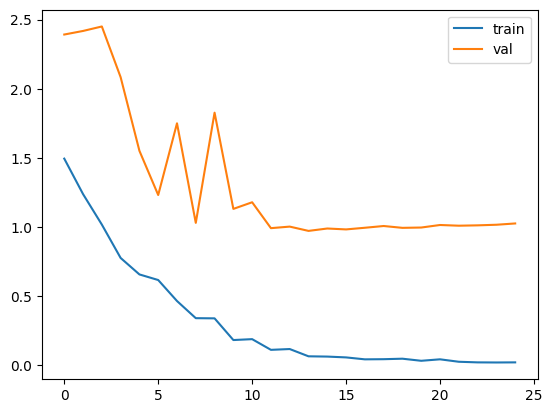

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

 15. Đánh giá mô hình:

In [ ]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print('Evaluation on val/test dataset')
print('Val accuracy:', val_acc)
print('Test accuracy:', test_acc)

Evaluation on val/test dataset
Val accuracy: 0.697742170429716
Test accuracy: 0.6839708561020036


In [ ]:
import torch
import torch.nn as nn
import numpy as np

data = np.array([[[1, 6], [3, 4]]])
data = torch.tensor(data, dtype=torch.float32)

bnorm = nn.BatchNorm2d(1)
data = data.unsqueeze(0)
with torch.no_grad():
  output = bnorm(data)
  print(output)

tensor([[[[-1.3867,  1.3867],
          [-0.2773,  0.2773]]]])


In [ ]:
import torch
a = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([[1, 2], [3, 4]])

a = a.reshape(1, 2, 2)
b = b.reshape(1, 2, 2)
c = torch.cat((a, b))
print(c)

tensor([[[1, 2],
         [3, 4]],

        [[1, 2],
         [3, 4]]])


In [ ]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)
input_tensor = torch.tensor([[[[1.0, 2.0], [3.0, 4.0]]]])

conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1)
conv_output = conv_layer(input_tensor)

with torch.no_grad():
  output = conv_output + input_tensor
  print(output)

tensor([[[[1.0739, 2.5891],
          [4.1044, 5.6197]]]])


## **Scenes Classification**

In [ ]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  seed = 59
  set_seed(seed)

In [ ]:
!unzip /content/img_cls_scenes_classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: scenes_classification/train/mountain/16162.jpg  
  inflating: scenes_classification/train/mountain/16173.jpg  
  inflating: scenes_classification/train/mountain/16225.jpg  
  inflating: scenes_classification/train/mountain/16322.jpg  
  inflating: scenes_classification/train/mountain/16341.jpg  
  inflating: scenes_classification/train/mountain/16350.jpg  
  inflating: scenes_classification/train/mountain/16374.jpg  
  inflating: scenes_classification/train/mountain/16375.jpg  
  inflating: scenes_classification/train/mountain/16417.jpg  
  inflating: scenes_classification/train/mountain/1642.jpg  
  inflating: scenes_classification/train/mountain/16421.jpg  
  inflating: scenes_classification/train/mountain/16438.jpg  
  inflating: scenes_classification/train/mountain/16560.jpg  
  inflating: scenes_classification/train/mountain/16599.jpg  
  inflating: scenes_classification/train/mountain/16645.jpg  
  inflating: scenes_

In [ ]:
root_dir = 'scenes_classification'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'val')
classes = {
  label_idx: class_name\
  for label_idx, class_name in enumerate(sorted(os.listdir(train_dir)))
   }

In [ ]:
X_train = []
y_train = []
y_test = []
X_test = []

for dataset_path in [ train_dir , test_dir ]:
  for label_idx, class_name in classes.items():
    class_dir = os.path.join(dataset_path, class_name)
    for img_filename in os.listdir(class_dir):
      img_path = os.path.join(class_dir , img_filename)
      if 'train' in dataset_path :
        X_train.append(img_path)
        y_train.append(label_idx)
      else :
        X_test.append(img_path)
        y_test.append(label_idx)

In [ ]:
val_size = 0.2
is_shuffle = True
seed = 0
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=seed, shuffle=is_shuffle)

In [ ]:
class ScenesDataset(Dataset):
  def __init__(self, X, y, transform=None):
    self.transform = transform
    self.img_paths = X
    self.labels = y

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    img = Image.open(img_path).convert("RGB")

    if self.transform:
      img = self.transform(img)

    return img, self.labels[idx]

In [ ]:
def transform(img, img_size=(224, 224)):
  img = img.resize(img_size)
  img = np.array(img)[..., :3]
  img = torch.tensor(img).permute(2, 0, 1).float()
  normalized_img = img/255.0

  return normalized_img

In [ ]:
train_dataset = ScenesDataset(X_train, y_train, transform=transform)
val_dataset = ScenesDataset(X_val, y_val, transform=transform)
test_dataset = ScenesDataset(X_test, y_test, transform=transform)

In [ ]:
train_batch_size = 64
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [ ]:
class BottleneckBlock(nn.Module):
  def __init__(self, in_channels, growth_rate):
    super(BottleneckBlock, self).__init__()
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.conv1 = nn.Conv2d(in_channels, 4*growth_rate, kernel_size=1, bias = False)
    self.bn2 = nn.BatchNorm2d(4*growth_rate)
    self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias = False)
    self.relu = nn.ReLU()

  def forward(self, x):
    res = x.clone().detach()
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv1(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv2(x)
    x =  torch.cat([res, x], dim=1)

    return x
class DenseBlock (nn.Module ) :
  def __init__ (self, num_layers, in_channels, growth_rate ) :
    super ( DenseBlock , self ).__init__ ()
    layers = []
    for i in range (num_layers ) :
      layers.append(BottleneckBlock ( in_channels + i *growth_rate , growth_rate ) )
    self.block = nn.Sequential(*layers )

  def forward(self, x) :
    return self.block (x)

In [ ]:
class DenseNet (nn. Module ) :
  def __init__ (self , num_blocks , growth_rate , num_classes ) :
    super ( DenseNet , self ) . __init__ ()
    self . conv1 = nn. Conv2d (3 , 2 * growth_rate , kernel_size =7 , padding =3 , stride =2 , bias = False )
    self . bn1 = nn. BatchNorm2d (2 * growth_rate )
    self . pool1 = nn. MaxPool2d ( kernel_size =3 , stride =2 , padding =1)

    self . dense_blocks = nn. ModuleList ()
    in_channels = 2 * growth_rate
    for i, num_layers in enumerate ( num_blocks ) :
      self . dense_blocks . append ( DenseBlock ( num_layers , in_channels , growth_rate ) )
      in_channels += num_layers * growth_rate
      if i != len ( num_blocks ) - 1:
        out_channels = in_channels // 2
        self . dense_blocks . append (nn. Sequential (nn. BatchNorm2d ( in_channels ) , nn. Conv2d ( in_channels , out_channels , kernel_size=1, bias = False ) , nn.AvgPool2d (kernel_size =2, stride =2)) )
        in_channels = out_channels

    self . bn2 = nn. BatchNorm2d ( in_channels )
    self . pool2 = nn. AvgPool2d ( kernel_size =7)
    self . relu = nn. ReLU ()
    self .fc = nn. Linear ( in_channels , num_classes )

  def forward (self, x) :
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    for block in self.dense_blocks :
      x = block (x)

    x = self . bn2 (x)
    x = self . relu (x)
    x = self . pool2 (x)
    x = x. view (x. size (0) , -1)
    x = self .fc(x)

    return x

In [ ]:
n_classes = len( list ( classes . keys () ) )
device = 'cuda' if torch . cuda . is_available () else 'cpu'
model = DenseNet([6 , 12 , 24 , 16], growth_rate =32, num_classes = n_classes).to( device )

In [ ]:
model.eval()
dummy_tensor=torch.randn(1,3,224,224).to(device)
with torch.no_grad():
  out=model(dummy_tensor)
print(out.shape)

torch.Size([1, 6])


In [ ]:
lr = 1e-2
epochs = 15

criterion = nn. CrossEntropyLoss ()
optimizer = torch . optim.SGD (model . parameters (),lr=lr)

In [ ]:
train_losses, val_losses = fit(model , train_loader , val_loader , criterion , optimizer , device , epochs)

EPOCH 1:	Train loss: 1.2424	Val loss: 1.2933
EPOCH 2:	Train loss: 1.1854	Val loss: 1.1619
EPOCH 3:	Train loss: 1.1294	Val loss: 1.0904
EPOCH 4:	Train loss: 0.8446	Val loss: 1.0336
EPOCH 5:	Train loss: 0.9664	Val loss: 0.9741
EPOCH 6:	Train loss: 1.0662	Val loss: 0.9246
EPOCH 7:	Train loss: 0.7016	Val loss: 0.8723
EPOCH 8:	Train loss: 0.9037	Val loss: 0.8512
EPOCH 9:	Train loss: 0.8002	Val loss: 0.7938
EPOCH 10:	Train loss: 1.0454	Val loss: 0.7750
EPOCH 11:	Train loss: 0.6890	Val loss: 0.7445
EPOCH 12:	Train loss: 0.7184	Val loss: 0.7118
EPOCH 13:	Train loss: 1.0165	Val loss: 0.6862
EPOCH 14:	Train loss: 0.5287	Val loss: 0.6696
EPOCH 15:	Train loss: 0.6448	Val loss: 0.6517


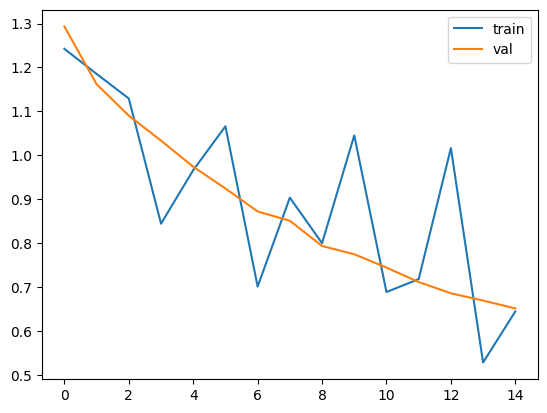

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

In [ ]:
val_loss, val_acc = evaluate (model ,val_loader ,criterion, device)
test_loss, test_acc = evaluate (model, test_loader, criterion, device)

print ('Evaluation on val/test dataset')
print ('Val accuracy :', val_acc )
print ('Test accuracy :', test_acc )

Evaluation on val/test dataset
Val accuracy : 0.7727110794442466
Test accuracy : 0.7796666666666666
